<a href="https://colab.research.google.com/github/Nord-ouest-Advisors/InvestGuard/blob/main/InvestGuard.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

Functions to compute financial quantities

In [2]:
def daily_returns(data):
    """Returns DataFrame with daily returns (percentage change)
    :math:`\\displaystyle R = \\dfrac{\\text{price}_{t_i} - \\text{price}_{t_{i-1}}}{\\text{price}_{t_{i-1}}}`
    :Input:
     :data: ``pandas.DataFrame`` with daily stock prices
    :Output:
     :ret: a ``pandas.DataFrame`` of daily percentage change of Returns
         of given stock prices.
    """
    return data.pct_change().dropna(how="all").replace([np.inf, -np.inf], np.nan)

def cumulative_returns(data, dividend=0):
    """Returns DataFrame with cumulative returns
    :math:`\\displaystyle R = \\dfrac{\\text{price}_{t_i} - \\text{price}_{t_0} + \\text{dividend}}{\\text{price}_{t_0}}`
    :Input:
     :data: ``pandas.DataFrame`` with daily stock prices
     :dividend: ``float`` (default= ``0``), paid dividend
    :Output:
     :ret: a ``pandas.DataFrame`` of cumulative Returns of given stock prices.
    """
    if isinstance(data, pd.Series):
        data = pd.DataFrame(data)
    return data.dropna(axis=0, how="any").apply(lambda x: (x - x[0] + dividend) / x[0])

def historical_mean_return(data, freq=252):
    """Returns the mean return based on historical stock price data.
    :Input:
     :data: ``pandas.DataFrame`` with daily stock prices
     :freq: ``int`` (default= ``252``), number of trading days, default
             value corresponds to trading days in a year
    :Output:
     :ret: a ``pandas.DataFrame`` of historical mean Returns.
    """
    if not isinstance(data, pd.DataFrame):
        raise ValueError("data must be a pandas.DataFrame")
    return daily_returns(data).mean() * freq

def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1


def annualize_vol(r, periods_per_year):
    """
    Annualizes the vol of a set of returns
    We should infer the periods per year
    but that is currently left as an exercise
    to the reader :-)
    """
    return r.std()*(periods_per_year**0.5)


def sharpe_ratio(r, riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns
    """
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for
       the wealth index, 
       the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})
    
def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix
    """
    return weights.T @ returns


def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix
    """
    return (weights.T @ covmat @ weights)**0.5    

def weighted_mean(means, weights):
    """Computes the weighted mean/average, or in the case of a
    financial portfolio, it can be used for the Expected Return
    of said portfolio.
    :Input:
     :means: ``numpy.ndarray``/``pd.Series`` of mean/average values
     :weights: ``numpy.ndarray``/``pd.Series`` of weights
    :Output:
     :weighted mu: ``numpy.ndarray``: ``(np.sum(means*weights))``
    """
    if not isinstance(weights, (pd.Series, np.ndarray)):
        raise ValueError("weights is expected to be a pandas.Series/np.ndarray")
    if not isinstance(means, (pd.Series, np.ndarray)):
        raise ValueError("means is expected to be a pandas.Series/np.ndarray")
    return np.sum(means * weights)


def weighted_std(cov_matrix, weights):
    """Computes the weighted standard deviation, or Volatility of
    a portfolio, which contains several stocks.
    :Input:
     :cov_matrix: ``numpy.ndarray``/``pandas.DataFrame``, covariance matrix
     :weights: ``numpy.ndarray``/``pd.Series`` of weights
    :Output:
     :weighted sigma: ``numpy.ndarray``:
         ``np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))``
    """
    if not isinstance(weights, (pd.Series, np.ndarray)):
        raise ValueError("weights is expected to be a pandas.Series, np.array")
    if not isinstance(cov_matrix, (np.ndarray, (np.ndarray, pd.DataFrame))):
        raise ValueError(
            "cov_matrix is expected to be a numpy.ndarray/pandas.DataFrame"
        )
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))


def sharpe_ratio(exp_return, volatility, risk_free_rate=0.005):
    """Computes the Sharpe Ratio
    :Input:
     :exp_return: ``int``/``float``, Expected Return of a portfolio
     :volatility: ``int``/``float``, Volatility of a portfolio
     :risk_free_rate: ``int``/``float`` (default= ``0.005``), risk free rate
    :Output:
     :sharpe ratio: ``float`` ``(exp_return - risk_free_rate)/float(volatility)``
    """
    if not isinstance(
        exp_return, (int, float, np.int32, np.int64, np.float32, np.float64)
    ):
        raise ValueError("exp_return is expected to be an integer or float.")
    if not isinstance(
        volatility, (int, float, np.int32, np.int64, np.float32, np.float64)
    ):
        raise ValueError("volatility is expected to be an integer or float.")
    if not isinstance(
        risk_free_rate, (int, float, np.int32, np.int64, np.float32, np.float64)
    ):
        raise ValueError("risk_free_rate is expected to be an integer or float.")
    return (exp_return - risk_free_rate) / float(volatility)


def annualised_portfolio_quantities(weights, means, cov_matrix, risk_free_rate=0.005, freq=252):
    """Computes and returns the expected annualised return, volatility
    and Sharpe Ratio of a portfolio.
    :Input:
     :weights: ``numpy.ndarray``/``pd.Series`` of weights
     :means: ``numpy.ndarray``/``pd.Series`` of mean/average values
     :cov_matrix: ``numpy.ndarray``/``pandas.DataFrame``, covariance matrix
     :risk_free_rate: ``float`` (default= ``0.005``), risk free rate
     :freq: ``int`` (default= ``252``), number of trading days, default
         value corresponds to trading days in a year
    :Output:
     :(Expected Return, Volatility, Sharpe Ratio): tuple of those
         three quantities
    """
    if not isinstance(freq, int):
        raise ValueError("freq is expected to be an integer.")
    expected_return = weighted_mean(means, weights) * freq
    volatility = weighted_std(cov_matrix, weights) * np.sqrt(freq)
    sharpe = sharpe_ratio(expected_return, volatility, risk_free_rate)
    return (expected_return, volatility, sharpe)

In [3]:
trnx_url = 'https://raw.githubusercontent.com/Nord-ouest-Advisors/InvestGuard/main/data/SampleTransactions.csv?token=ATIZFFVOVFH4FDFT3E5JACLAY3VSA'
prices_url = 'https://raw.githubusercontent.com/Nord-ouest-Advisors/InvestGuard/main/data/Prices.csv?token=ATIZFFRAZPQAW4CE7SLEYODAY3VTY'
info_url = 'https://raw.githubusercontent.com/Nord-ouest-Advisors/InvestGuard/main/data/FundsInfo.csv?token=ATIZFFVW6AOPSMBNG473IKLAY3VV2'

In [4]:
def get_transactions(url):
    trnx = pd.read_csv(url)
    trnx['InstructionDate'] = pd.to_datetime(trnx['InstructionDate'])
    trnx.sort_values(by=['FundPortfolio','InstructionDate'], inplace=True)
    return trnx

def get_prices(url):
    prices = pd.read_csv(url)
    prices['Date'] = pd.to_datetime(prices['Date'])
    prices.sort_values(by=['FundISIN', 'Date'], inplace=True)
    prices.set_index(['Date'], inplace=True)
    prices.reset_index(inplace=True)
    return prices

def get_funds_info(url):
    info = pd.read_csv(info_url)
    info['FundNameAdj'] = info['FundName']+"("+info['Currency']+")"
    return info

def get_names_dict(url):
    info = pd.read_csv(info_url)
    info['FundNameAdj'] = info['FundName']+"("+info['Currency']+")"
    info_copy = info.copy()
    cols = ['FundISIN','FundNameAdj']
    info_copy = info_copy[cols].set_index('FundISIN')
    info_dict = {isin:info_copy.loc[isin][0] for isin in info_copy.index}
    return info_dict


In [5]:
trnx = get_transactions(trnx_url)
prices = get_prices(prices_url)
info = get_funds_info(info_url)
names = get_names_dict(info_url)

In [6]:
portfolios_dict = {portfolio:trnx[trnx['FundPortfolio']==portfolio] for portfolio in trnx['FundPortfolio'].unique()}
portfolios_dict

{'PopularPortfolio_01':   CustomerID InstructionDate      FundISIN  ...  NetAmount PricePerUnit       Units
 0      Admin      2013-01-22  LU1883861137  ...  424315.59         8.27  51307.8096
 1      Admin      2013-01-22  LU1882449801  ...  939173.97        11.70  80271.2793
 2      Admin      2013-01-22  LU1882447425  ...  835156.88        19.12  43679.7529
 3      Admin      2013-01-22  LU1883306497  ...  435508.89        98.84   4406.2008
 4      Admin      2013-01-22  LU0557854147  ...  727962.28        99.42   7322.0909
 5      Admin      2013-01-22  LU0568620560  ...  266795.00       100.98   2642.0578
 6      Admin      2013-01-22  LU0557858130  ...  394552.59       102.41   3852.6763
 7      Admin      2013-01-22  LU1883854199  ...  376595.05       103.97   3622.1511
 8      Admin      2013-01-22  LU1883318740  ...  826505.62       166.61   4960.7204
 
 [9 rows x 13 columns],
 'PopularPortfolio_02':    CustomerID InstructionDate  ... PricePerUnit       Units
 9       Admin   

In [7]:
prtfl_trnx = portfolios_dict['PopularPortfolio_04']
prtfl_prices = prices[(prices['FundISIN'].isin(prtfl_trnx['FundISIN'].unique())) & (prices['Date']>=prtfl_trnx['InstructionDate'].min())]
prtfl_trnx

,CustomerID,InstructionDate,FundISIN,FundName,FundCurrency,FundOperation,FundPortfolio,GrossAmount,Fee,FeeAmount,NetAmount,PricePerUnit,Units
12,Admin,2019-07-31,LU1983299246,SCHRODER ISF HEALTHCARE INNOVATION,USD,Buy,PopularPortfolio_04,951549,0.0150,14273.24,937275.77,100.00,9372.7577
13,Admin,2019-07-31,LU1049752592,AMUNDI FUNDS GLOBAL AGGREGATE BOND,USD,Buy,PopularPortfolio_04,607958,0.0075,4559.69,603398.32,113.55,5313.9438
14,Admin,2019-07-31,LU1883306570,AMUNDI FUNDS EUROPEAN EQUITY SMALL CAP,USD,Buy,PopularPortfolio_04,603396,0.0150,9050.94,594345.06,181.76,3269.9442


In [21]:
def prices_fill(prices):
    df = prices.set_index('Date')
    #period = pd.date_range(start=prices.index.min(), end=prices.index.max(), freq='d')
    #prices_df = pd.DataFrame(index=period, columns = prices['FundISIN'].unique())
    return df


In [9]:
prtfl_prices.head()

,Date,FundISIN,FundNAV
33385,2019-07-31,LU1049752592,113.55
33386,2019-08-01,LU1049752592,113.89
33387,2019-08-02,LU1049752592,114.13
33388,2019-08-05,LU1049752592,114.08
33389,2019-08-06,LU1049752592,114.33


In [10]:
prtfl_prices_df = prtfl_prices.set_index('Date')
prtfl_prices_df = prtfl_prices_df.pivot(columns=['FundISIN']).fillna(method='bfill')
prtfl_prices_df.columns = [col[1] for col in prtfl_prices_df.columns]
prtfl_prices_df.rename(columns=names, inplace=True)
prtfl_prices_df.head()

,AMUNDI FUNDS GLOBAL AGGREGATE BOND (USD),AMUNDI FUNDS EUROPEAN EQUITY SMALL CAP (USD),SCHRODER ISF HEALTHCARE INNOVATION(USD)
Date,,,
2019-07-31,113.55,181.76,100.0000
2019-08-01,113.89,181.14,100.1407
2019-08-02,114.13,177.62,99.6260
2019-08-05,114.08,174.65,97.5020
2019-08-06,114.33,174.36,96.4027


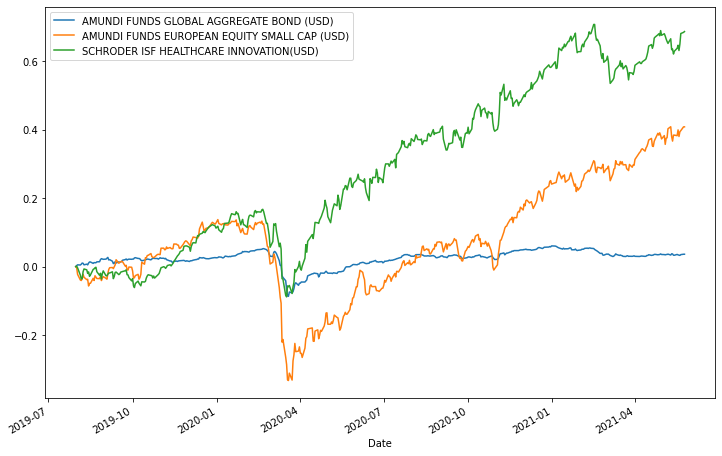

In [11]:
cumulative_returns(prtfl_prices_df).plot(figsize=(12,8), legend=True)

In [22]:
end_date = prtfl_prices['Date'].max()

def daily_snapshot(transactions):

    period_start = transactions['InstructionDate'].min()
    period = pd.date_range(start=period_start, end=end_date)
    daily_snapshot = []
    for date in period:
        daily_position = transactions[transactions['InstructionDate'] <= date]
        daily_position['DateSnapshot'] = date
        daily_snapshot.append(daily_position)
  
    return daily_snapshot

def modified_cost_per_unit(transactions, prices):
    df = pd.merge(transactions, prices, left_on=['DateSnapshot', 'FundISIN'], right_on=['Date','FundISIN'], how='left')
    df.rename(columns={'FundNAV':'AdjPricePerUnit'}, inplace=True)
    df = df.fillna(method='bfill')
    df['AdjCostDaily'] = round(df['Units'] * df['AdjPricePerUnit'],2)
    return df

In [23]:
trnx_df = daily_snapshot(prtfl_trnx)
trnx_df[20]

,CustomerID,InstructionDate,FundISIN,FundName,FundCurrency,FundOperation,FundPortfolio,GrossAmount,Fee,FeeAmount,NetAmount,PricePerUnit,Units,DateSnapshot
12,Admin,2019-07-31,LU1983299246,SCHRODER ISF HEALTHCARE INNOVATION,USD,Buy,PopularPortfolio_04,951549,0.0150,14273.24,937275.77,100.00,9372.7577,2019-08-20
13,Admin,2019-07-31,LU1049752592,AMUNDI FUNDS GLOBAL AGGREGATE BOND,USD,Buy,PopularPortfolio_04,607958,0.0075,4559.69,603398.32,113.55,5313.9438,2019-08-20
14,Admin,2019-07-31,LU1883306570,AMUNDI FUNDS EUROPEAN EQUITY SMALL CAP,USD,Buy,PopularPortfolio_04,603396,0.0150,9050.94,594345.06,181.76,3269.9442,2019-08-20


In [28]:
combined_df = modified_cost_per_unit(pd.concat(trnx_df), prtfl_prices)
combined_df = combined_df.drop('Date',axis=1)
combined_df.tail(6)

,CustomerID,InstructionDate,FundISIN,FundName,FundCurrency,FundOperation,FundPortfolio,GrossAmount,Fee,FeeAmount,NetAmount,PricePerUnit,Units,DateSnapshot,AdjPricePerUnit,AdjCostDaily
1989,Admin,2019-07-31,LU1983299246,SCHRODER ISF HEALTHCARE INNOVATION,USD,Buy,PopularPortfolio_04,951549,0.0150,14273.24,937275.77,100.00,9372.7577,2021-05-24,168.5143,1579443.70
1990,Admin,2019-07-31,LU1049752592,AMUNDI FUNDS GLOBAL AGGREGATE BOND,USD,Buy,PopularPortfolio_04,607958,0.0075,4559.69,603398.32,113.55,5313.9438,2021-05-24,168.7500,896728.02
1991,Admin,2019-07-31,LU1883306570,AMUNDI FUNDS EUROPEAN EQUITY SMALL CAP,USD,Buy,PopularPortfolio_04,603396,0.0150,9050.94,594345.06,181.76,3269.9442,2021-05-24,168.7500,551803.08
1992,Admin,2019-07-31,LU1983299246,SCHRODER ISF HEALTHCARE INNOVATION,USD,Buy,PopularPortfolio_04,951549,0.0150,14273.24,937275.77,100.00,9372.7577,2021-05-25,168.7500,1581652.86
1993,Admin,2019-07-31,LU1049752592,AMUNDI FUNDS GLOBAL AGGREGATE BOND,USD,Buy,PopularPortfolio_04,607958,0.0075,4559.69,603398.32,113.55,5313.9438,2021-05-25,117.6600,625238.63
1994,Admin,2019-07-31,LU1883306570,AMUNDI FUNDS EUROPEAN EQUITY SMALL CAP,USD,Buy,PopularPortfolio_04,603396,0.0150,9050.94,594345.06,181.76,3269.9442,2021-05-25,256.0600,837301.91
